In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb


from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifier 
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
    roc_auc_score,
    roc_curve,
    average_precision_score,
    precision_recall_curve,
    precision_score,
    recall_score
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
    cross_val_predict,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from scipy.stats import expon, lognorm, loguniform, randint, uniform

from sklearn.feature_selection import RFECV
from sklearn.utils.class_weight import compute_sample_weight

import eli5
import shap

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs): #Cite: CPSC330 UBC course
    scores = cross_validate(model, X_train, y_train, **kwargs)
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []
    for i in range(len(mean_scores)):
        out_col.append((f"%0.4f (+/- %0.4f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

/kaggle/input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv


# **A comprehensive study on the default of credit card clients dataset**
 by Arman Abtahi, PhD candidate at Institute of Applied Mathematics, Univerituty of British Columbia

## Table of Contents

- [Contents](#Contents)
- [Understanding the problem](#Understanding)
- [EDA](#EDA)
- [Feature engineering](#Feature)
- [Preprocessing and transformations](#Preprocessing)
- [Linear models](#Linear)
- [Different classifiers](#Different)
- [Feature selection](#Featureselection)
- [Hyperparameter optimization](#Hyperparameter)
- [Interpretation and feature importances](#Interpretation)
- [Results on the test set](#Results)
- [Summary of results](#Summary)



This dataset is gathered in Taiwan from April 2005 to September 2005 and contains information on default payments, history of payments and bill statements. You can download the dataset [here](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset). The contents of this dataset is as follows.

## Contents <a name="Contents"></a>
There are 24 features and 1 label in this dataset:

**ID:** ID of each client

**LIMIT_BAL:** Amount of given credit in NT dollars (includes individual and family/supplementary credit

**SEX:** Gender (1=male, 2=female)

**EDUCATION:** (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

**MARRIAGE:** Marital status (1=married, 2=single, 3=others)

**AGE:** Age in years

**PAY_0:** Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)

**PAY_2:** Repayment status in August, 2005 (scale same as above)

**PAY_3:** Repayment status in July, 2005 (scale same as above)

**PAY_4:** Repayment status in June, 2005 (scale same as above)

**PAY_5:** Repayment status in May, 2005 (scale same as above)

**PAY_6:** Repayment status in April, 2005 (scale same as above)

**BILL_AMT1:** Amount of bill statement in September, 2005 (NT dollar)

**BILL_AMT2:** Amount of bill statement in August, 2005 (NT dollar)

**BILL_AMT3:** Amount of bill statement in July, 2005 (NT dollar)

**BILL_AMT4:** Amount of bill statement in June, 2005 (NT dollar)

**BILL_AMT5:** Amount of bill statement in May, 2005 (NT dollar)

**BILL_AMT6:** Amount of bill statement in April, 2005 (NT dollar)

**PAY_AMT1:** Amount of previous payment in September, 2005 (NT dollar)

**PAY_AMT2:** Amount of previous payment in August, 2005 (NT dollar)

**PAY_AMT3:** Amount of previous payment in July, 2005 (NT dollar)

**PAY_AMT4:** Amount of previous payment in June, 2005 (NT dollar)

**PAY_AMT5:** Amount of previous payment in May, 2005 (NT dollar)

**PAY_AMT6:** Amount of previous payment in April, 2005 (NT dollar)

**default.payment.next.month:** Default payment (1=yes, 0=no)


## Understanding the problem <a name="Understanding"></a>

Dataset has 30,000 examples and 24 features. The ultimate goal is to estimate whether a person will default on their credit card bills next month.

Let's take a look at the dataset.

In [2]:
df = pd.read_csv("../input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv")
print(df.shape)
df.info()

(30000, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2          

The good thing about this dataset is that there is no missing value and consequently we do not need any imputation. Looking at features, we see an irrelevant feature called "ID", which is the identity of each client. This feature is not contributing to the prediction of default and should be dropped. Another feature that is worth thinking about is "SEX". Keeping this feature makes our model biased towards one gender. We look for this feature closely later on. We also need to rename the feature "PAY_0" to "PAY_1" for consistency.

The label or the target for this dataset is "default.payment.next.month".
We also keep 80% of data for training a model and 20% of data for testing the accuracy of our model.

In [3]:
df = df.rename(columns={"PAY_0":"PAY_1"})
df['LIMIT_BAL_bins']=pd.cut(df['LIMIT_BAL'],[0,10000, 20000, 30000, 40000, 50000, 100000, 200000, 300000, 400000, 500000, 1000000]).astype('str')
target="default.payment.next.month"
feats = list(df.drop(columns=target).columns)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)

## EDA <a name="EDA"></a>
To perform an exploratory data analysis on the train set, we begin with separating default and repay customers. We see that more than 78% of customers have paid their balance, while 22% have defaulted. In this case, this is an imbalanced dataset and we need to take care of that. Otherwise, the model predicts in favor of not defaulting and the bank cannot correctly predict defaulters.

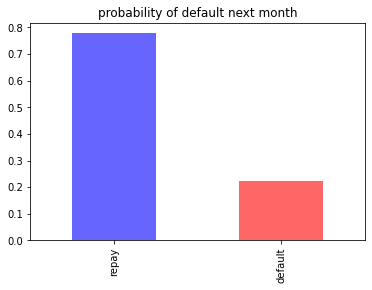

In [4]:
default=train_df[train_df[target] == 1]
repay=train_df[train_df[target] == 0]
train_df[target].value_counts(normalize=True).rename(index={0:"repay",1:"default"}).plot(kind="bar",color=["blue","red"],alpha=0.6,).set_title("probability of default next month");

These histograms show that most customers have less than 200,000 NT dollars in credit limit and also the majority of customers are near 30 years old. The average credit limit is 167,484 NT dollars and the standard deviation is 129,747 NT dollars.

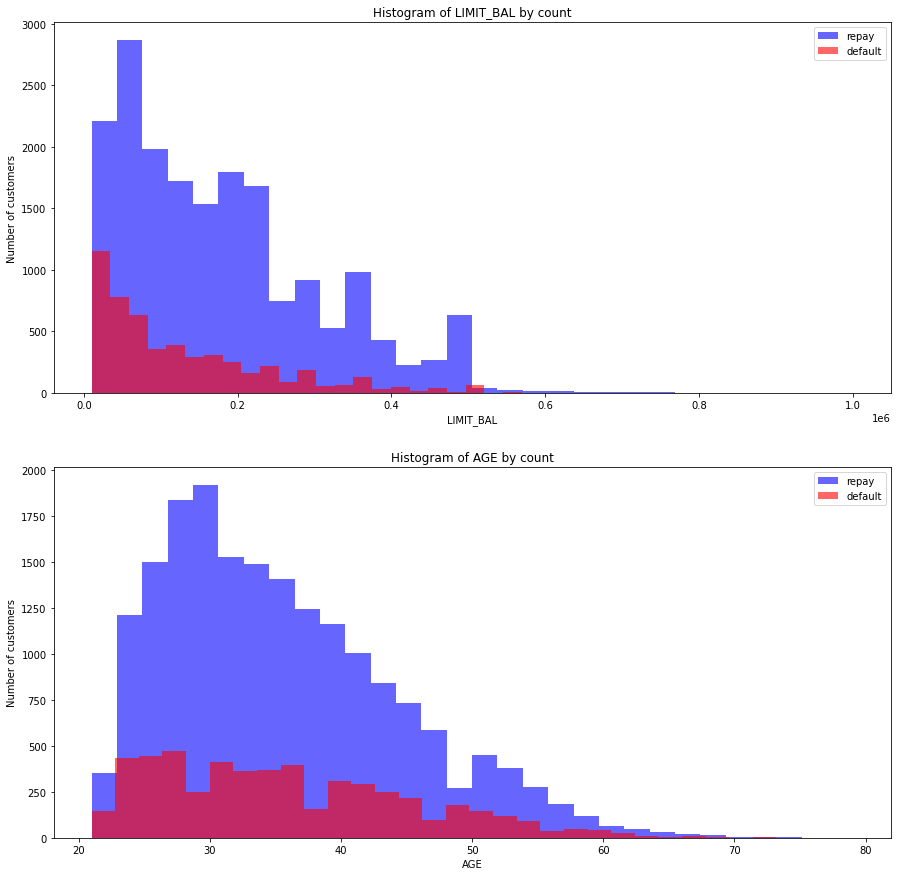

In [5]:
feature=["LIMIT_BAL","AGE"]
n=len(feature)
fig, ax = plt.subplots(n, sharey=False, figsize=[15, 15])
#fig.suptitle("Histograms of a couple of feature by target class")
for i,name in enumerate(feature):
    ax[i].hist(repay[[name]],bins=30 ,alpha=0.6, label='repay',color="blue")
    ax[i].hist(default[[name]],bins=30 ,alpha=0.6, label='default',color="red")
    ax[i].set_title("Histogram of " +name + " by count" )
    ax[i].set_xlabel(name)
    ax[i].set_ylabel('Number of customers')
    ax[i].legend(loc="upper right")

plt.show()

This figure shows that between 35% to 40% of customers with credit limits less than 40k NT dollars default while customers with higher credit limits default less. The conclusion is that customers with lower credit limits, default more than customers with higher credit limits.

<AxesSubplot:xlabel='Credit limit', ylabel='% default'>

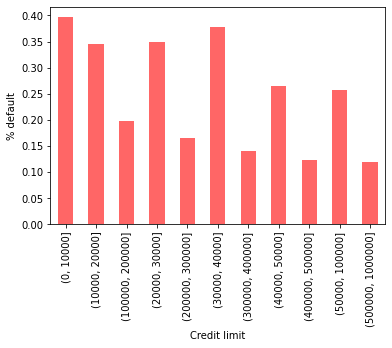

In [6]:
a=default['LIMIT_BAL_bins'].value_counts().sort_index()
b=repay['LIMIT_BAL_bins'].value_counts().sort_index()
(a/(a+b)).plot(kind='bar',alpha=0.6,label='repay',color='red',xlabel="Credit limit",ylabel="% default")

The figures below show that there is a high chance that customers having debt already default next month.

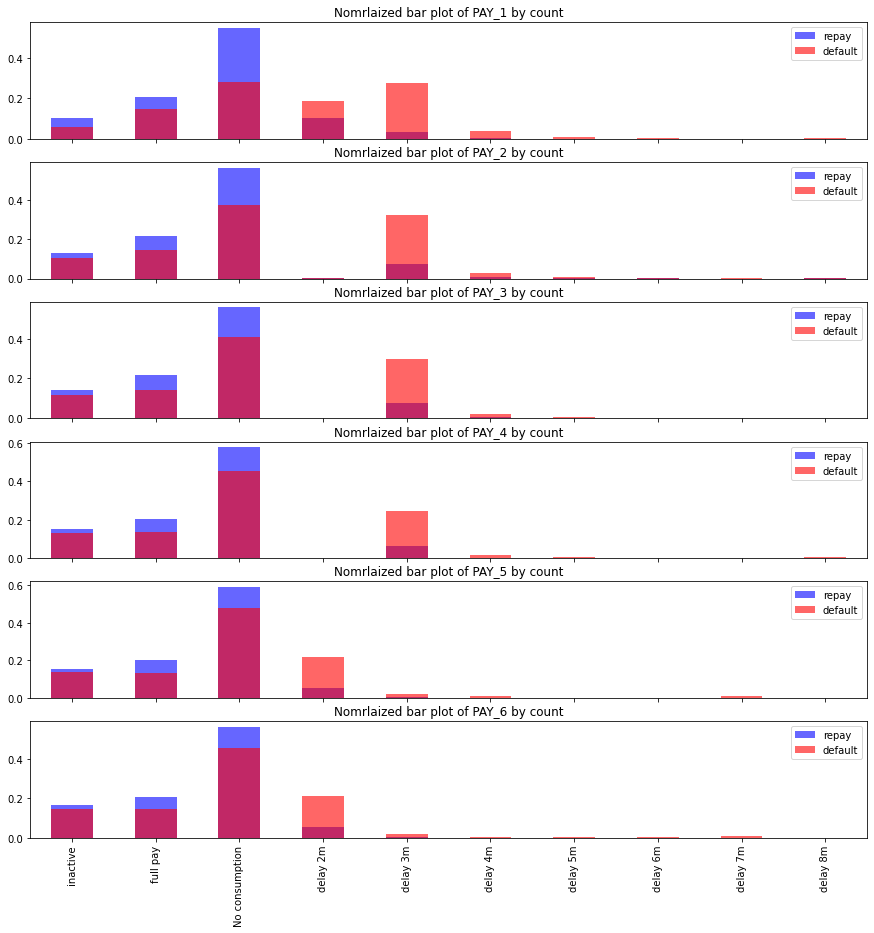

In [7]:
feature=["PAY_1","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]
n=len(feature)
list={-2:"inactive",-1:"full pay", 0:"No consumption",1:"delay 1m", 2:"delay 2m", 3:"delay 3m",4: "delay 4m",5: "delay 5m",6: "delay 6m",7: "delay 7m", 8:"delay 8m",9: "delay 9m"}
fig, ax = plt.subplots(n, sharex=True, figsize=[15, 15])
for i,name in enumerate(feature):
    repay2 = repay[name].value_counts(normalize=True).sort_index().rename(index=list)
    default2 = default[name].value_counts(normalize=True).sort_index().rename(index=list)
    repay2.plot(kind='bar',alpha=0.6, ax=ax[i],label='repay',color='blue').set_title("Nomrlaized bar plot of " +name + " by count" )
    default2.plot(kind='bar',alpha=0.6, ax=ax[i],label='default',color='red').set_title("Nomrlaized bar plot of " +name + " by count" )
    ax[i].legend(loc="upper right")

plt.show()

An interesting result from the figures below is that defaulters are mostly university graduates! Also, unmarried customers have a bit higher probability to default next month.

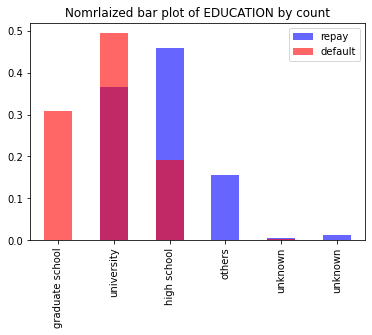

In [8]:
list={0:'unknown',1:'graduate school', 2:'university', 3:'high school', 4:'others', 5:'unknown', 6:'unknown'}
repay2 = repay["EDUCATION"].value_counts(normalize=True).sort_index().rename(index=list)
default2 = default["EDUCATION"].value_counts(normalize=True).sort_index().rename(index=list)
repay2.plot(kind='bar',alpha=0.6, label='repay',color='blue',legend='repay').set_title("Nomrlaized bar plot of EDUCATION by count" )
default2.plot(kind='bar',alpha=0.6, label='default',color='red',legend='default');

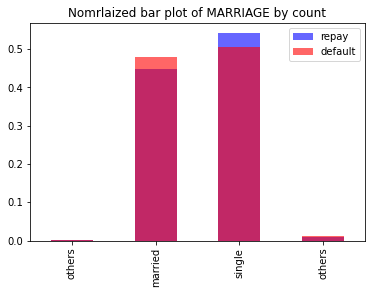

In [9]:
list={1:'married', 2:'single', 3:'others', 0:'others'}
repay2 = repay["MARRIAGE"].value_counts(normalize=True).sort_index().rename(index=list)
default2 = default["MARRIAGE"].value_counts(normalize=True).sort_index().rename(index=list)
repay2.plot(kind='bar',alpha=0.6, label='repay',color='blue',legend='repay').set_title("Nomrlaized bar plot of MARRIAGE by count" )
default2.plot(kind='bar',alpha=0.6, label='default',color='red',legend='default');

Gender results are not balanced and show that men would default more relative to the total number of customers. 

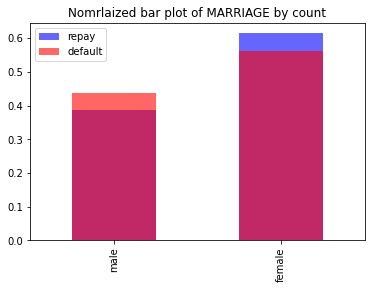

In [10]:
list={1:'male', 2:'female'}
repay2 = repay["SEX"].value_counts(normalize=True).sort_index().rename(index=list)
default2 = default["SEX"].value_counts(normalize=True).sort_index().rename(index=list)
repay2.plot(kind='bar',alpha=0.6, label='repay',color='blue',legend='repay').set_title("Nomrlaized bar plot of MARRIAGE by count" )
default2.plot(kind='bar',alpha=0.6, label='default',color='red',legend='default');

In general, a lot of clients pay less than the bill amount. We see that figure below has more data near the bill axis than the pay axis.

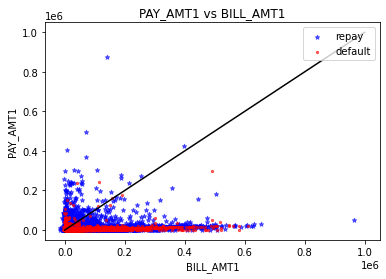

In [11]:
plt.scatter(repay["BILL_AMT1"],repay["PAY_AMT1"],marker="*",s=20,alpha=0.6, label='repay',color="blue")
plt.scatter(default["BILL_AMT1"],default["PAY_AMT1"],marker="o",s=5,alpha=0.6, label='default',color="red")
plt.plot([1,10**6],[1,10**6],color="black")
plt.legend(loc="upper right")
plt.ylabel("PAY_AMT1")
plt.xlabel("BILL_AMT1");
plt.title("PAY_AMT1 vs BILL_AMT1");

Now that we have a good sense of the dataset, and know that there is a class imbalance (22% defaulters) I would pick recall score to pick fewer false negatives. Bank usually needs to identify more customers that may default. But at the same time, I look for roc-auc too. This measurement helps us to pick the best possible model.

## Feature engineering <a name="Feature"></a>

This section deals with feature engineering. We take a look at the heat map of the feature correlation for unscaled data. We see many highly correlated variables: Payments and Bill amounts are highly correlated, especially every two consecutive bills. But this type of behavior is acceptable when we have lag-type variables. Payments are the status of payments in the past 6 months, as well as Bill amounts. Moreover, the prediction for next month's default is highly dependent on the payment status in the last six months.

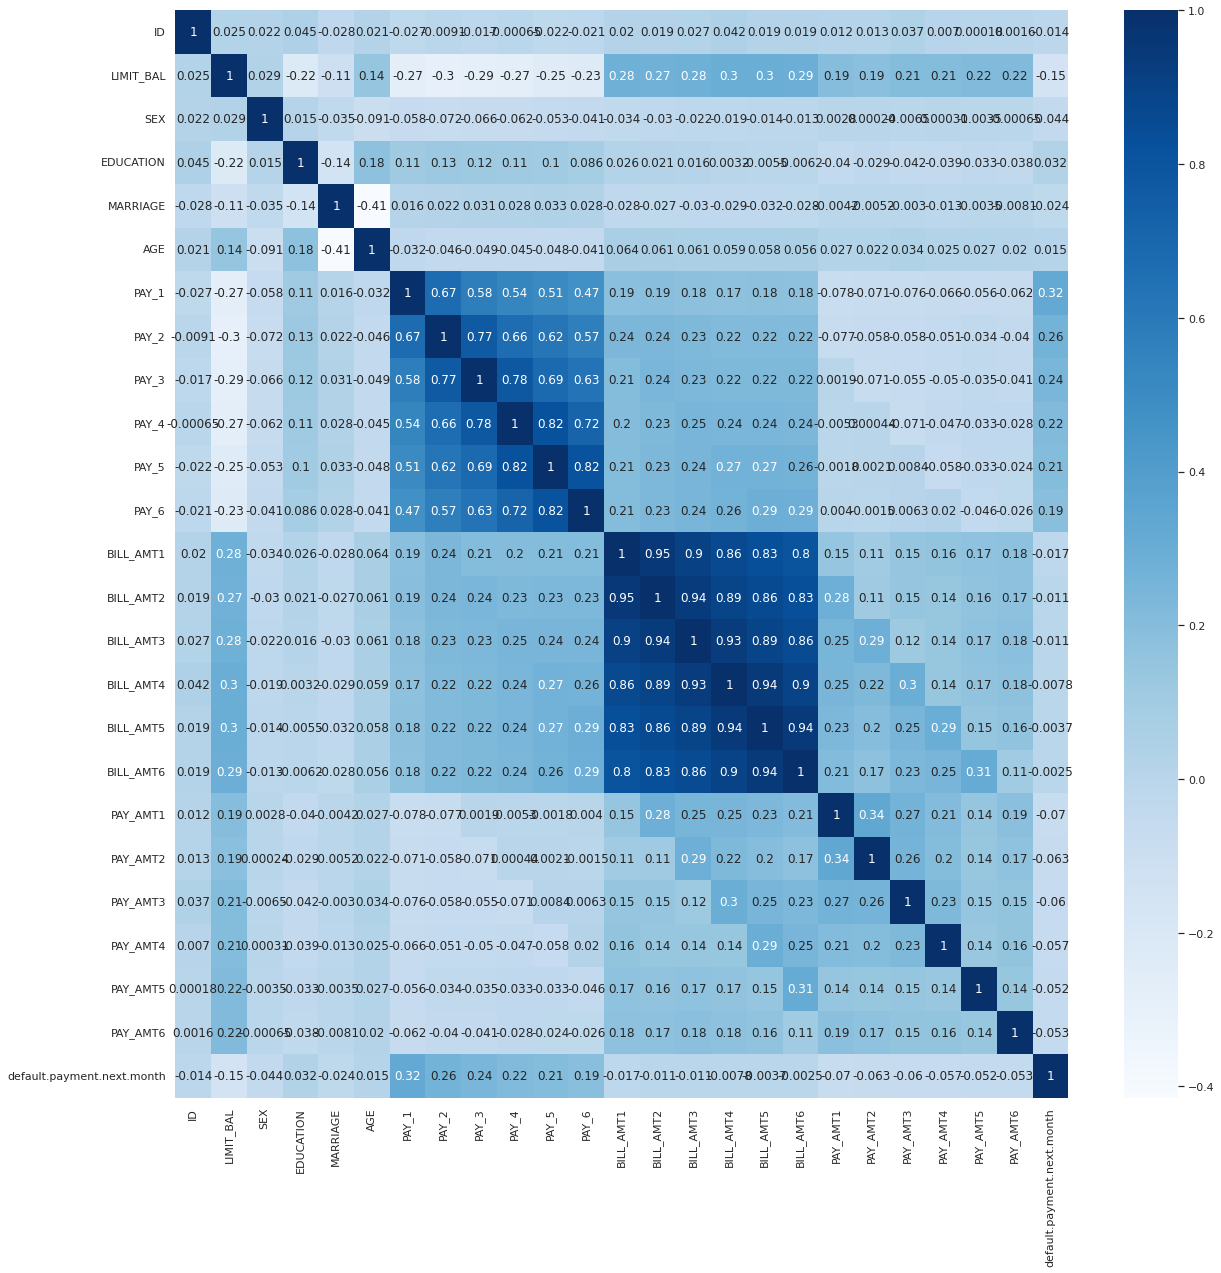

In [12]:
cor = train_df.corr()
plt.figure(figsize=(20, 20))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

## Preprocessing and transformations <a name="Preprocessing"></a>
Let's begin by identifying different feature types and the transformations that we want to apply to each feature type. We treat PAY_X feature as an ordinal feature. An ordinal feature is similar to a categorical feature. However, there is a clear ordering of the categories. The higher the value of this feature, the more months the customers have delayed their payment. "Marriage" and "Education" are among categorical features although education seems to be ordinal. We keep this feature in the categorical list as there are a couple of unknown entries for education that there is no proper interpretation for them. Furthermore, we drop the feature "SEX" to prevent future bias towards one gender.

In [13]:
X_train=train_df.drop(columns=target)
X_test=test_df.drop(columns=target)
y_train=train_df[target]
y_test=test_df[target]

numerical_features=[ 'LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
ordinal_features=['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
categorical_features=['MARRIAGE','EDUCATION']
passthrough_features = []
drop_features=['ID','SEX','LIMIT_BAL_bins']

features=numerical_features+ordinal_features+categorical_features+passthrough_features+drop_features
assert set(features)==set(feats)

numeric_transformer=make_pipeline(SimpleImputer(strategy="median"),StandardScaler())
ordinal_transformer=make_pipeline(SimpleImputer(strategy="most_frequent"))
categorical_transformer=make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown='ignore',sparse=False))

preprocessor=make_column_transformer(
    (numeric_transformer,numerical_features),
    (ordinal_transformer,ordinal_features),
    (categorical_transformer,categorical_features),
    ("passthrough",passthrough_features),
    ("drop",drop_features),
)

X_train_transformed=preprocessor.fit_transform(X_train)

column_names=(
    numerical_features
    +ordinal_features
    +preprocessor.named_transformers_["pipeline-3"].named_steps["onehotencoder"].get_feature_names_out(categorical_features).tolist()
    +passthrough_features
)
X_train_transformed=pd.DataFrame(X_train_transformed,index=X_train.index, columns=column_names)
X_train_transformed.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6
19682,0.246770,1.140423,0.757746,0.761414,0.830643,0.929712,0.901952,0.444775,-0.117221,-0.042650,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11062,-0.368109,-0.378471,-0.647736,-0.684308,-0.677352,-0.664583,-0.648784,-0.646675,-0.298634,-0.261604,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
197,-1.136707,-1.463396,-0.443283,-0.415538,-0.405142,-0.542919,-0.352021,-0.327893,-0.248029,-0.228531,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
23620,-0.521828,-0.161486,0.553566,0.595190,0.585249,-0.312957,-0.535129,-0.597934,-0.038927,-0.098349,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
26031,0.938509,-0.703949,-0.596367,-0.573988,-0.560226,-0.536136,-0.511737,-0.483417,-0.270109,-0.206514,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


All data are scaled and ready to be fed into a model. Scaling numerical features is required for our algorithm. When features are at the same scale, the algorithm can compare the features on the same scale and can understand the relative relations better.

## Linear models <a name="Linear"></a>

We try logistic regression as a first attempt followed by hyperparameter tuning to get the best possible model and prevent overfitting. We look for different scoring metrics for now to have an idea of the performance of the model. To be safe and not break the golden rule, we always work with training data. For hyperparameter optimization, we pass cross-validation to the model. Also, we balance the classes to get a better recall score and predict more defaulters.

In [14]:
scores={}
scoring=["accuracy", "precision", "recall","f1","roc_auc","average_precision"]
pipe_lr_none=make_pipeline(preprocessor,LogisticRegression(max_iter=1000))
scores["class weight: None"]=mean_std_cross_val_scores(pipe_lr_none,  X_train,y_train,scoring=scoring,cv=5,return_train_score=True)

pipe_lr_balanced=make_pipeline(preprocessor,LogisticRegression(class_weight="balanced",max_iter=1000))
scores["class weight: Balanced"]=mean_std_cross_val_scores(pipe_lr_balanced,  X_train,y_train,scoring=scoring,cv=5,return_train_score=True)

pd.DataFrame(scores)

,class weight: None,class weight: Balanced
fit_time,0.8370 (+/- 0.0647),0.7619 (+/- 0.1098)
score_time,0.0653 (+/- 0.0016),0.0658 (+/- 0.0014)
test_accuracy,0.8100 (+/- 0.0045),0.6836 (+/- 0.0080)
train_accuracy,0.8106 (+/- 0.0015),0.6838 (+/- 0.0032)
test_precision,0.7215 (+/- 0.0270),0.3756 (+/- 0.0107)
train_precision,0.7242 (+/- 0.0036),0.3763 (+/- 0.0035)
test_recall,0.2359 (+/- 0.0194),0.6405 (+/- 0.0250)
train_recall,0.2384 (+/- 0.0099),0.6436 (+/- 0.0045)
test_f1,0.3553 (+/- 0.0237),0.4735 (+/- 0.0146)
train_f1,0.3587 (+/- 0.0114),0.4749 (+/- 0.0036)


In [15]:
cm_none=confusion_matrix(y_train, cross_val_predict(pipe_lr_none, X_train, y_train))
cm_balanced=confusion_matrix(y_train, cross_val_predict(pipe_lr_balanced, X_train, y_train))
print("class weight: None\nTN=%d  FP=%d\nFN=%d   TP=%d"%(cm_none[0,0],cm_none[0,1],cm_none[1,0],cm_none[1,1]))
print("\nclass weight: Balanced\nTN=%d  FP=%d\nFN=%d   TP=%d"%(cm_balanced[0,0],cm_balanced[0,1],cm_balanced[1,0],cm_balanced[1,1]))

class weight: None
TN=18182  FP=486
FN=4074   TP=1258

class weight: Balanced
TN=12992  FP=5676
FN=1917   TP=3415


We already can see that by balancing the classes, we get a better recall score and fewer false negatives. The cost associated with it is the higher number of false positives. So the bank predicts more defaulters, but also some customers that are not going to default are recognized as next month's defaulters. 

In [16]:
param = [0.001, 0.01, 0.1, 1.0, 10, 100]
scores={}
best_score=0
for C in param:
    pipe_lr=make_pipeline(preprocessor,LogisticRegression(solver='lbfgs',penalty='l2',class_weight="balanced",C=C,max_iter=1000))
    scores["C="+str(round(C,3))]=mean_std_cross_val_scores(pipe_lr,  X_train,y_train,scoring=scoring,cv=5,return_train_score=True)
    if best_score<float(scores["C="+str(round(C,3))]["test_recall"][:6]):
        best_score=float(scores["C="+str(round(C,3))]["test_recall"][:6])
        best_C=C
    
pd.DataFrame(scores)   

,C=0.001,C=0.01,C=0.1,C=1.0,C=10,C=100
fit_time,0.1814 (+/- 0.0163),0.2983 (+/- 0.0415),0.5800 (+/- 0.1247),0.7343 (+/- 0.1230),0.8313 (+/- 0.1050),1.0435 (+/- 0.2279)
score_time,0.0644 (+/- 0.0022),0.0651 (+/- 0.0021),0.0731 (+/- 0.0143),0.0640 (+/- 0.0013),0.0644 (+/- 0.0015),0.0639 (+/- 0.0007)
test_accuracy,0.6901 (+/- 0.0067),0.6883 (+/- 0.0075),0.6855 (+/- 0.0077),0.6836 (+/- 0.0080),0.6834 (+/- 0.0080),0.6833 (+/- 0.0081)
train_accuracy,0.6906 (+/- 0.0037),0.6884 (+/- 0.0039),0.6854 (+/- 0.0032),0.6838 (+/- 0.0032),0.6834 (+/- 0.0031),0.6834 (+/- 0.0032)
test_precision,0.3796 (+/- 0.0090),0.3794 (+/- 0.0102),0.3773 (+/- 0.0103),0.3756 (+/- 0.0107),0.3754 (+/- 0.0107),0.3753 (+/- 0.0108)
train_precision,0.3805 (+/- 0.0040),0.3801 (+/- 0.0043),0.3776 (+/- 0.0034),0.3763 (+/- 0.0035),0.3759 (+/- 0.0034),0.3759 (+/- 0.0035)
test_recall,0.6226 (+/- 0.0292),0.6339 (+/- 0.0242),0.6397 (+/- 0.0245),0.6405 (+/- 0.0250),0.6405 (+/- 0.0248),0.6405 (+/- 0.0248)
train_recall,0.6249 (+/- 0.0051),0.6378 (+/- 0.0042),0.6421 (+/- 0.0044),0.6436 (+/- 0.0045),0.6435 (+/- 0.0045),0.6436 (+/- 0.0045)
test_f1,0.4715 (+/- 0.0138),0.4746 (+/- 0.0140),0.4746 (+/- 0.0141),0.4735 (+/- 0.0146),0.4733 (+/- 0.0146),0.4733 (+/- 0.0147)
train_f1,0.4730 (+/- 0.0037),0.4763 (+/- 0.0042),0.4756 (+/- 0.0035),0.4749 (+/- 0.0036),0.4746 (+/- 0.0035),0.4746 (+/- 0.0036)


In [17]:
print("The best validation recall score is  %4.4f" %best_score)
print("The best value found for C is C=%2.3f and the class_weight set to \"balanced\"" %(best_C))
pipe_lr_balanced_C=make_pipeline(preprocessor,LogisticRegression(max_iter=1000,class_weight="balanced",C=best_C))
cm_balanced_C=confusion_matrix(y_train, cross_val_predict(pipe_lr_balanced_C, X_train, y_train))
print("\nclass weight: Balanced,  C=%.3f\nTN=%d  FP=%d\nFN=%d   TP=%d"%(best_C,cm_balanced_C[0,0],cm_balanced_C[0,1],cm_balanced_C[1,0],cm_balanced_C[1,1]))

The best validation recall score is  0.6405
The best value found for C is C=1.000 and the class_weight set to "balanced"

class weight: Balanced,  C=1.000
TN=12992  FP=5676
FN=1917   TP=3415


With a balanced weight, we can get a recall score of 64% and 37.5% precision. Looking at different loss functions and regularization didn't help improve any scores.
Let's see if we can get a better recall score using different classifiers.

## Different classifiers <a name="Different"></a>
Let's try different classifiers.

In [18]:
sample_weights = compute_sample_weight(class_weight='balanced',y=y_train)
class_weight=y_train.value_counts()[0]/y_train.value_counts()[1]

pipe_lr = make_pipeline(preprocessor, LogisticRegression(max_iter=2000,class_weight="balanced", C=best_C))
pipe_r = make_pipeline(preprocessor, RidgeClassifier(max_iter=2000,class_weight="balanced"))
pipe_knn = make_pipeline(preprocessor, KNeighborsClassifier())
pipe_lsvc = make_pipeline(preprocessor, LinearSVC(max_iter=3000,class_weight="balanced"))
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(class_weight="balanced"))
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(class_weight="balanced"))
pipe_xgb = make_pipeline(preprocessor, XGBClassifier(verbosity=0,use_label_encoder=False,sample_weight=sample_weights))
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(class_weight="balanced"))
pipe_catboost = make_pipeline(preprocessor, CatBoostClassifier(verbose=0,class_weights = (1, class_weight)))

classifiers = {
    "logistic regression": pipe_lr,
    #"ridge classifier": pipe_r,
    #"knn": pipe_knn,
    "linear svc": pipe_lsvc,
    "decision tree": pipe_dt,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catboost,
}

results = {}
for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring, cv=5
    )
pd.DataFrame(results)

Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.


,logistic regression,linear svc,decision tree,random forest,XGBoost,LightGBM,CatBoost
fit_time,0.6932 (+/- 0.0999),11.3492 (+/- 0.5086),0.5154 (+/- 0.0226),5.1795 (+/- 0.0573),3.3551 (+/- 0.4615),0.4051 (+/- 0.0206),7.2935 (+/- 0.1783)
score_time,0.0640 (+/- 0.0016),0.0605 (+/- 0.0039),0.0389 (+/- 0.0015),0.2859 (+/- 0.0044),0.0579 (+/- 0.0006),0.0619 (+/- 0.0011),0.1606 (+/- 0.0031)
test_accuracy,0.6836 (+/- 0.0080),0.6901 (+/- 0.0085),0.7329 (+/- 0.0055),0.8152 (+/- 0.0062),0.8128 (+/- 0.0065),0.7642 (+/- 0.0071),0.7699 (+/- 0.0082)
train_accuracy,0.6838 (+/- 0.0032),0.6902 (+/- 0.0032),0.9989 (+/- 0.0002),0.9989 (+/- 0.0002),0.8935 (+/- 0.0027),0.8157 (+/- 0.0016),0.8355 (+/- 0.0025)
test_precision,0.3756 (+/- 0.0107),0.3814 (+/- 0.0117),0.3977 (+/- 0.0138),0.6577 (+/- 0.0244),0.6389 (+/- 0.0247),0.4765 (+/- 0.0124),0.4857 (+/- 0.0146)
train_precision,0.3763 (+/- 0.0035),0.3819 (+/- 0.0035),0.9953 (+/- 0.0008),0.9960 (+/- 0.0008),0.9022 (+/- 0.0097),0.5633 (+/- 0.0029),0.5987 (+/- 0.0046)
test_recall,0.6405 (+/- 0.0250),0.6352 (+/- 0.0256),0.3938 (+/- 0.0211),0.3501 (+/- 0.0185),0.3618 (+/- 0.0220),0.6206 (+/- 0.0181),0.6043 (+/- 0.0137)
train_recall,0.6436 (+/- 0.0045),0.6374 (+/- 0.0061),1.0000 (+/- 0.0000),0.9992 (+/- 0.0003),0.5839 (+/- 0.0088),0.7576 (+/- 0.0084),0.7869 (+/- 0.0044)
test_f1,0.4735 (+/- 0.0146),0.4766 (+/- 0.0157),0.3957 (+/- 0.0171),0.4569 (+/- 0.0210),0.4618 (+/- 0.0229),0.5391 (+/- 0.0147),0.5385 (+/- 0.0143)
train_f1,0.4749 (+/- 0.0036),0.4776 (+/- 0.0038),0.9976 (+/- 0.0004),0.9976 (+/- 0.0004),0.7089 (+/- 0.0079),0.6462 (+/- 0.0037),0.6800 (+/- 0.0045)


It seems the best performing algorithms in terms of recall score are LogisticRegression and LightGBM. Linear SVC also gives a high recall, but fitting time is extremely high. We can also take a look into the confusion matrix for each of the classifiers.

In [19]:
for (name, model) in classifiers.items():
    cm=confusion_matrix(y_train, cross_val_predict(model, X_train, y_train,cv=5))
    print("\n %s \nTN=%d  FP=%d\nFN=%d   TP=%d"%(name,cm[0,0],cm[0,1],cm[1,0],cm[1,1]))


 logistic regression 
TN=12992  FP=5676
FN=1917   TP=3415


Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.



 linear svc 
TN=13179  FP=5489
FN=1955   TP=3377

 decision tree 
TN=15463  FP=3205
FN=3217   TP=2115

 random forest 
TN=17691  FP=977
FN=3474   TP=1858

 XGBoost 
TN=17578  FP=1090
FN=3403   TP=1929

 LightGBM 
TN=15033  FP=3635
FN=2023   TP=3309

 CatBoost 
TN=15255  FP=3413
FN=2110   TP=3222


From these confusion matrices, it's better to pick either logisticRegression or LightGBM. LogisticRegression gives a lot of false positives. We can make sure by taking a look into ROC and precision-recall curves too. For this, we split the train set into another train, the validation set.

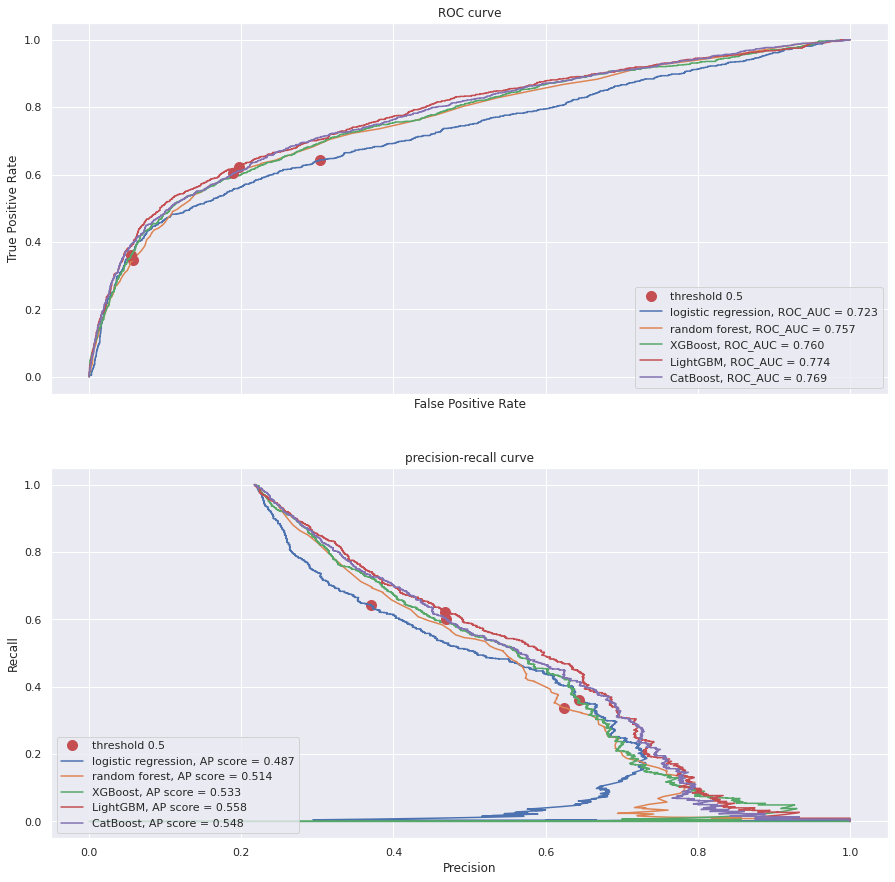

In [20]:
X_train2,X_valid,y_train2,y_valid = train_test_split(X_train,y_train, test_size=0.2, random_state=123)
classifiers_proba = {
    "logistic regression": pipe_lr,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catboost,
}
fig, ax = plt.subplots(2, sharex=True, figsize=[15, 15])
i=0
for (name, model) in classifiers_proba.items():
    model.fit(X_train2,y_train2)
    model_pred_proba=model.predict_proba(X_valid)[:, 1]
    model_roc_auc = roc_auc_score(y_valid, model_pred_proba)
    model_fpr, model_tpr, model_thresholds = roc_curve(y_valid,model_pred_proba)
    default_threshold = np.argmin(np.abs(model_thresholds - 0.5))
    if i==0:
        ax[0].plot(model_fpr[default_threshold],model_tpr[default_threshold],"or",markersize=10,label="threshold 0.5")
    else:
        ax[0].plot(model_fpr[default_threshold],model_tpr[default_threshold],"or",markersize=10)
    ax[0].plot(model_fpr,model_tpr, label = name+', ROC_AUC = %0.3f' % model_roc_auc)
    ax[0].set_xlabel("False Positive Rate", fontsize= 12)
    ax[0].set_ylabel("True Positive Rate", fontsize= 12)
    ax[0].set_title("ROC curve")
    ax[0].legend(loc="lower right")
    i=i+1
i=0    
for (name, model) in classifiers_proba.items():    
    model.fit(X_train2,y_train2)
    model_pred_proba=model.predict_proba(X_valid)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_valid, model_pred_proba)
    ap = average_precision_score(y_valid, model_pred_proba)
    if i==0:
        ax[1].plot(precision_score(y_valid, model.predict(X_valid)),recall_score(y_valid, model.predict(X_valid)),"or",markersize=10,label="threshold 0.5")
    else:
        ax[1].plot(precision_score(y_valid, model.predict(X_valid)),recall_score(y_valid, model.predict(X_valid)),"or",markersize=10)
    ax[1].plot(precision, recall, label= name+', AP score = %0.3f' % ap)
    ax[1].set_ylabel("Recall")
    ax[1].set_xlabel("Precision")
    ax[1].set_title("precision-recall curve")
    ax[1].legend(loc="lower left")
    i=i+1

None is beating the recall score of linear regression. However, LightGBM gives better f1, AP and roc-auc scores. But I also look more into RandomForest and CatBoost. These classifiers have low recall scores, but hyperparameter tuning might get good scores (They are overfitting).
In this problem, there is a high cost for the bank when we have a large number of false negatives since no actions can be taken and high false positives when the bank needs to investigate a lot of customers who probably won't default.

## Feature selection <a name="Featureselection"></a>

We may try to select relevant features using RFECV. First, let's take a look at the coefficients of the best LogisticRegression model.

In [21]:
pipe_lr.fit(X_train,y_train)
lr_coefs = pd.DataFrame(pipe_lr[1].coef_.T, index=column_names, columns=["Coefficient"])
lr_coefs.sort_values(by=["Coefficient"],ascending=False)

,Coefficient
EDUCATION_1,0.539898
PAY_1,0.494504
EDUCATION_3,0.489330
EDUCATION_2,0.460192
EDUCATION_6,0.294026
BILL_AMT2,0.166976
MARRIAGE_1,0.149802
MARRIAGE_3,0.128406
BILL_AMT5,0.098985
PAY_2,0.086200


We can see that top and bottom features are the most important ones. "EDUCATION_0" is a big negative number because, in our data set, all customers in this category have repaid their statements (We explored this in EDA). In general, EDUCATION and PAY_1 have higher impacts. We can remove the least important features using Recursive feature elimination RFE.

In [22]:
rfe_cv = RFECV(LogisticRegression(max_iter=2000), cv=5,min_features_to_select=5)
rfe_cv.fit(X_train_transformed, y_train)
features_select=np.array(column_names)
print(features_select[np.array(rfe_cv.support_, dtype=bool)])

['PAY_1' 'MARRIAGE_0' 'EDUCATION_0' 'EDUCATION_4' 'EDUCATION_5']


X does not have valid feature names, but RFECV was fitted with feature names


Now we can put this linear feature selection into our pipelines and see whether we get any improvements.

In [23]:
feature_selector=RFECV(LogisticRegression(max_iter=2000), cv=5,min_features_to_select=5)

pipe_rfe_lr = make_pipeline(
    preprocessor,feature_selector,
    LogisticRegression(max_iter=1000,class_weight="balanced", C=best_C),
)

pipe_rfe_rf = make_pipeline(
    preprocessor, feature_selector,
    RandomForestClassifier(class_weight="balanced")
)

pipe_rfe_catboost = make_pipeline(
    preprocessor,feature_selector,
    CatBoostClassifier(verbose=0,class_weights = (1, class_weight))
)


pipe_rfe_lgbm = make_pipeline(
    preprocessor,feature_selector,
    LGBMClassifier(class_weight="balanced")
)

classifiers_rfe = {
    "rfe_logistic regression": pipe_rfe_lr,
    "rfe_random forest": pipe_rfe_rf,
    "rfe_CatBoost": pipe_rfe_catboost,
    "rfe_LightGBM": pipe_rfe_lgbm,
}

results_rfe = {}
for (name, model) in classifiers_rfe.items():
    results_rfe[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring, cv=5
    )
pd.DataFrame(results_rfe)

,rfe_logistic regression,rfe_random forest,rfe_CatBoost,rfe_LightGBM
fit_time,52.6439 (+/- 3.4555),52.3028 (+/- 3.7673),54.9663 (+/- 3.4896),52.2599 (+/- 4.0504)
score_time,0.0628 (+/- 0.0023),0.1288 (+/- 0.0083),0.0449 (+/- 0.0010),0.0572 (+/- 0.0020)
test_accuracy,0.7685 (+/- 0.0271),0.7806 (+/- 0.0073),0.7805 (+/- 0.0072),0.7807 (+/- 0.0070)
train_accuracy,0.7692 (+/- 0.0266),0.7813 (+/- 0.0019),0.7811 (+/- 0.0018),0.7809 (+/- 0.0019)
test_precision,0.4861 (+/- 0.0457),0.5062 (+/- 0.0160),0.5060 (+/- 0.0159),0.5065 (+/- 0.0155)
train_precision,0.4877 (+/- 0.0441),0.5076 (+/- 0.0042),0.5073 (+/- 0.0040),0.5068 (+/- 0.0044)
test_recall,0.5240 (+/- 0.0304),0.5114 (+/- 0.0180),0.5118 (+/- 0.0178),0.5131 (+/- 0.0179)
train_recall,0.5244 (+/- 0.0256),0.5132 (+/- 0.0042),0.5136 (+/- 0.0042),0.5135 (+/- 0.0042)
test_f1,0.5024 (+/- 0.0213),0.5087 (+/- 0.0157),0.5088 (+/- 0.0156),0.5097 (+/- 0.0153)
train_f1,0.5034 (+/- 0.0157),0.5104 (+/- 0.0037),0.5105 (+/- 0.0038),0.5101 (+/- 0.0039)


Unfortunately, feature selection has reduced the recall score. So we keep all features for now! The next step is to tune the hyperparameter on the best models so far.

## Hyperparameter optimization <a name="Hyperparameter"></a>
In this section, we optimize hyperparameters for the chosen models. Then we can pick the best performing model. To do this, we use RandomizedSearchCV. The benefits of random search over grid search are explained [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html).

<font color='green'>
    
### 1. CatBoost

In [24]:
param_dist = {
    "catboostclassifier__max_depth": randint(5, 15),
    "catboostclassifier__learning_rate": [ 0.1, 0.2, 0.3],
    "catboostclassifier__n_estimators": randint(1, 50),
}
random_search_cb = RandomizedSearchCV(pipe_catboost, param_distributions=param_dist, n_jobs=-1, n_iter=20, cv=5,scoring="roc_auc",random_state=123)
random_search_cb.fit(X_train, y_train);
print("The best roc_auc score for CatBoost is %.3f "%random_search_cb.best_score_)
pd.DataFrame(random_search_cb.cv_results_)[
    [
        "param_catboostclassifier__max_depth",
        "param_catboostclassifier__learning_rate",
        "param_catboostclassifier__n_estimators",
        "mean_test_score",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().head().T

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


The best roc_auc score for CatBoost is 0.781 


rank_test_score,1,2,3,4,5
param_catboostclassifier__max_depth,5,5,8,8,6
param_catboostclassifier__learning_rate,0.2,0.2,0.1,0.2,0.3
param_catboostclassifier__n_estimators,48,47,43,29,13
mean_test_score,0.780941,0.780874,0.780063,0.776876,0.775924
mean_fit_time,2.257421,2.098916,3.200085,2.256824,1.394011


<font color='green'>
    
### 2. LightGBM

In [25]:
param_dist = {
    "lgbmclassifier__num_leaves": randint(1, 100),
    "lgbmclassifier__min_child_samples": randint(1, 100),
    "lgbmclassifier__max_depth": randint(1, 100),
}
random_search_lgbm = RandomizedSearchCV(pipe_lgbm, param_distributions=param_dist, n_jobs=-1, n_iter=20, cv=5,scoring="roc_auc",random_state=123)
random_search_lgbm.fit(X_train, y_train);
print("The best roc_auc score for LGBM is %.3f"%random_search_lgbm.best_score_)
pd.DataFrame(random_search_lgbm.cv_results_)[
    [
        "param_lgbmclassifier__num_leaves",
        "param_lgbmclassifier__min_child_samples",
        "param_lgbmclassifier__max_depth",
        "mean_test_score",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().head().T

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


The best roc_auc score for LGBM is 0.781


rank_test_score,1,2,3,4,5
param_lgbmclassifier__num_leaves,8,40,23,16,26
param_lgbmclassifier__min_child_samples,49,85,11,19,97
param_lgbmclassifier__max_depth,62,3,59,78,47
mean_test_score,0.781397,0.779796,0.778222,0.778175,0.778074
mean_fit_time,0.609605,0.56696,0.792671,0.708169,0.834701


<font color='green'>
    
### 3. RandomForest

In [26]:
param_dist = {
    "randomforestclassifier__n_estimators": randint(1, 100),
    "randomforestclassifier__max_depth": randint(1, 100),
    "randomforestclassifier__class_weight": ["balanced"],
    "randomforestclassifier__max_features": ["auto"],
    "randomforestclassifier__bootstrap": [True],
    
}
random_search_rf = RandomizedSearchCV(pipe_rf, param_distributions=param_dist, n_jobs=-1, n_iter=20, cv=5,scoring="roc_auc",random_state=123)
random_search_rf.fit(X_train, y_train);
print("The best roc_auc score for RandomForest is %.3f"%random_search_rf.best_score_)
pd.DataFrame(random_search_rf.cv_results_)[
    [
        "param_randomforestclassifier__n_estimators",
        "param_randomforestclassifier__max_depth",
        "param_randomforestclassifier__class_weight",
        "param_randomforestclassifier__max_features",
        "param_randomforestclassifier__bootstrap",
        "mean_test_score",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().head().T

The best roc_auc score for RandomForest is 0.776


rank_test_score,1,2,3,4,5
param_randomforestclassifier__n_estimators,93,85,84,98,95
param_randomforestclassifier__max_depth,8,3,26,87,86
param_randomforestclassifier__class_weight,balanced,balanced,balanced,balanced,balanced
param_randomforestclassifier__max_features,auto,auto,auto,auto,auto
param_randomforestclassifier__bootstrap,True,True,True,True,True
mean_test_score,0.77581,0.765593,0.762108,0.76064,0.760104
mean_fit_time,3.681064,1.755867,6.435433,7.158432,7.1225


## Interpretation and feature importances <a name="Interpretation"></a>

In this section, we explain the feature importance of one of the best-performing models.

Feature importance in LightGBM model: 

In [27]:
pipe_lgbm.fit(X_train, y_train)
eli5.explain_weights(
    pipe_lgbm.named_steps["lgbmclassifier"], feature_names=column_names
)

Weight,Feature
0.4083,PAY_1
0.0569,LIMIT_BAL
0.0523,BILL_AMT1
0.0517,PAY_AMT2
0.0383,PAY_AMT1
0.0360,PAY_AMT3
0.0349,PAY_AMT6
0.0343,PAY_AMT4
0.0307,AGE
0.0297,BILL_AMT2


Feature importance in logistic regression model:

In [28]:
pipe_lr.fit(X_train, y_train)
eli5.explain_weights(
    pipe_lr.named_steps["logisticregression"], feature_names=column_names
)

Weight?,Feature
+0.540,EDUCATION_1
+0.495,PAY_1
+0.489,EDUCATION_3
+0.460,EDUCATION_2
+0.294,EDUCATION_6
+0.167,BILL_AMT2
+0.150,MARRIAGE_1
+0.128,MARRIAGE_3
+0.099,BILL_AMT5
+0.086,PAY_2


Unlike LogisticRegression, LightGBM has different weights on features. As a matter of fact, for LightGBM, PAY_1 is the only feature that has a high weight.

In [29]:
# load JS visualization code to notebook
shap.initjs()
lgbm_explainer = shap.TreeExplainer(pipe_lgbm.named_steps["lgbmclassifier"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_transformed);

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


<font color="green">
    
### Dependence plot
<font color="black">
We see that a delay in the payment of the most recent balance, PAY_1, leads to higher SHAP values which draw the prediction towards default, especially for those that have payment delays for 2 months. Also, the lower the credit limit, the higher the SHAP value. Thus customers that have less credit limit default more. Or in another word, a lower credit limit pushes the prediction toward default.

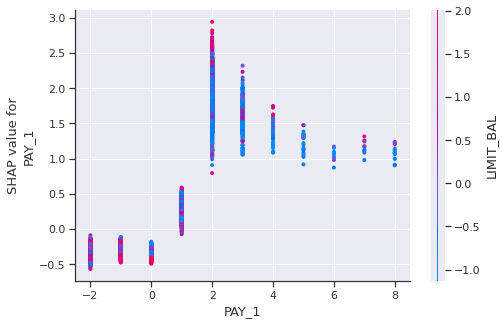

In [30]:
shap.dependence_plot("PAY_1", train_lgbm_shap_values[1], X_train_transformed)

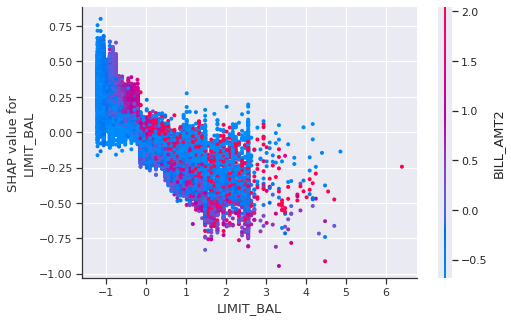

In [31]:
shap.dependence_plot("LIMIT_BAL", train_lgbm_shap_values[1], X_train_transformed)

<font color="green">
    
### Summary plot
<font color="black">
    
**PAY_X:**
This plot shows the PAY_1 is the most important feature for predicting the default. Customers with delayed payments default more than customers who have fully paid their debt so far.

**LIMIT_BAL:**
The lower the credit limit, the higher the chance of default next month.
    
**PAY_AMTX:**
The higher the payment, the less chance of default next month.

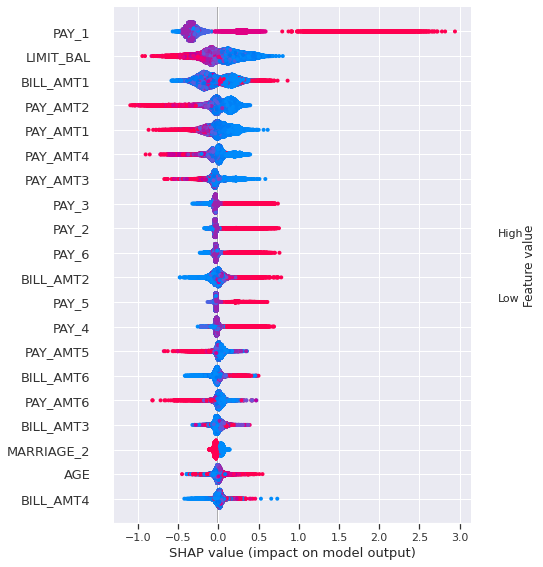

In [32]:
shap.summary_plot(train_lgbm_shap_values[1], X_train_transformed)

## Results on the test set <a name="Results"></a>

We choose the best-performing model and train it on the train data set. Then we pass the model on the test data and report test scores. We choose LightGBM classifier for this problem. It not only has a high recall score (just a little bit smaller than LogesticRegression), but also the highest roc_auc and ap scores.

In [33]:
pipe = make_pipeline(
    preprocessor, 
    LGBMClassifier(
        class_weight="balanced",
        max_depth=random_search_lgbm.best_params_["lgbmclassifier__max_depth"],
        min_child_samples=random_search_lgbm.best_params_["lgbmclassifier__min_child_samples"],
        num_leaves=random_search_lgbm.best_params_["lgbmclassifier__num_leaves"],
    )
)
pipe.fit(X_train,y_train);
pred_proba=pipe.predict_proba(X_test)[:, 1]
pred=pipe.predict(X_test)
print("The recall score is %.3f"% recall_score(y_test, pred))
print("The roc-auc score is %.3f"% roc_auc_score(y_test, pred))

The recall score is 0.654
The roc-auc score is 0.722


We see that both roc_auc and recall scores are consistent with the validation scores (They are a bit lower) and looking at the fairly large data set we have avoided optimization bias. We also check std over cross-validation to make sure nothing bizarre is happening.

## Explaining predictions

Let's use SHAP on test data and sample from these two classes.

In [34]:
X_test_transformed=pd.DataFrame(preprocessor.fit_transform(X_test),index=X_test.index, columns=column_names);
lgbm_explainer = shap.TreeExplainer(pipe.named_steps["lgbmclassifier"]);
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_transformed);
y_test_reset = y_test.reset_index(drop=True)
default_ind = y_test_reset[y_test_reset == 1].index.tolist()
repay_ind = y_test_reset[y_test_reset == 0].index.tolist()
ex_default_index = default_ind[10]
ex_repay_index = repay_ind[10]

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


<font color="green">
    
### Example with prediction: Default
    
    Here we see the default probability for this customer. The model is 50% confident that this customer defaults next month. But what features lead to this decision? We clearly see that most delays in payments of statements (PAY_1=2 and PAY_2=2) have contributed to predicting default.

In [35]:
pipe.named_steps["lgbmclassifier"].predict_proba(X_test_transformed)[ex_default_index]

array([0.15087827, 0.84912173])

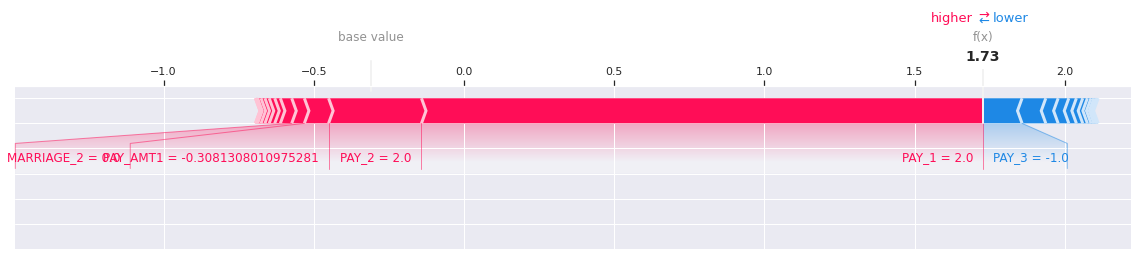

In [36]:
shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][ex_default_index, :],
    X_test_transformed.iloc[ex_default_index, :],
    matplotlib=True,
)

<font color="green">
    
### Example with prediction: repay
    
    
    For this example, which is a customer that pays their debt next month, the model is 82% confident in its decision. Repaying the statement (PAY_1=0) and low (scaled BILL_AMT1<0) and higher credit limit (LIMIT_BAL>0) have contributed to predicting repayment.

In [37]:
pipe.named_steps["lgbmclassifier"].predict_proba(X_test_transformed)[ex_repay_index]

array([0.82151333, 0.17848667])

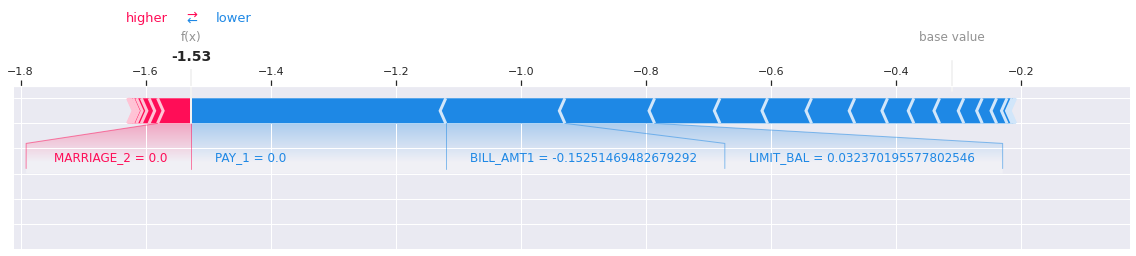

In [38]:
shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][ex_repay_index, :],
    X_test_transformed.iloc[ex_repay_index, :],
    matplotlib=True,
)

 ## Summary of results and Caveats <a name="Summary"></a>
To summarize, LightGBM gave us the best scores on the validation set. By hypertuning the model, we eliminated overfitting on the training dataset. Plus, we balanced the classes, so that we can predict more defaulters. Finally, we tested the trained model on the test set and see that the recall score is about 65%, and the precision roc-auc about 72%. These numbers are not very deviated from our validation scores which means that we successfully eliminated overfitting. A bank might want to detect more true positives and fewer false negatives. They can change the threshold but the cost would be more false positives as shown in the precision-recall curve.
Linear feature selection using a Logistic regression failed to improve performance. Maybe using a non-linear feature selection help.
We also can try stacking as well. That might improve the overall performance.

In [39]:
print("The recall score is %.3f."% recall_score(y_test, pred))
print("The roc-auc score is %.3f"% roc_auc_score(y_test, pred))
cm=confusion_matrix(y_test,pred)
print("\nConfusion Matrix\nTN=%d  FP=%d\nFN=%d   TP=%d"%(cm[0,0],cm[0,1],cm[1,0],cm[1,1]))

The recall score is 0.654.
The roc-auc score is 0.722

Confusion Matrix
TN=3708  FP=988
FN=451   TP=853


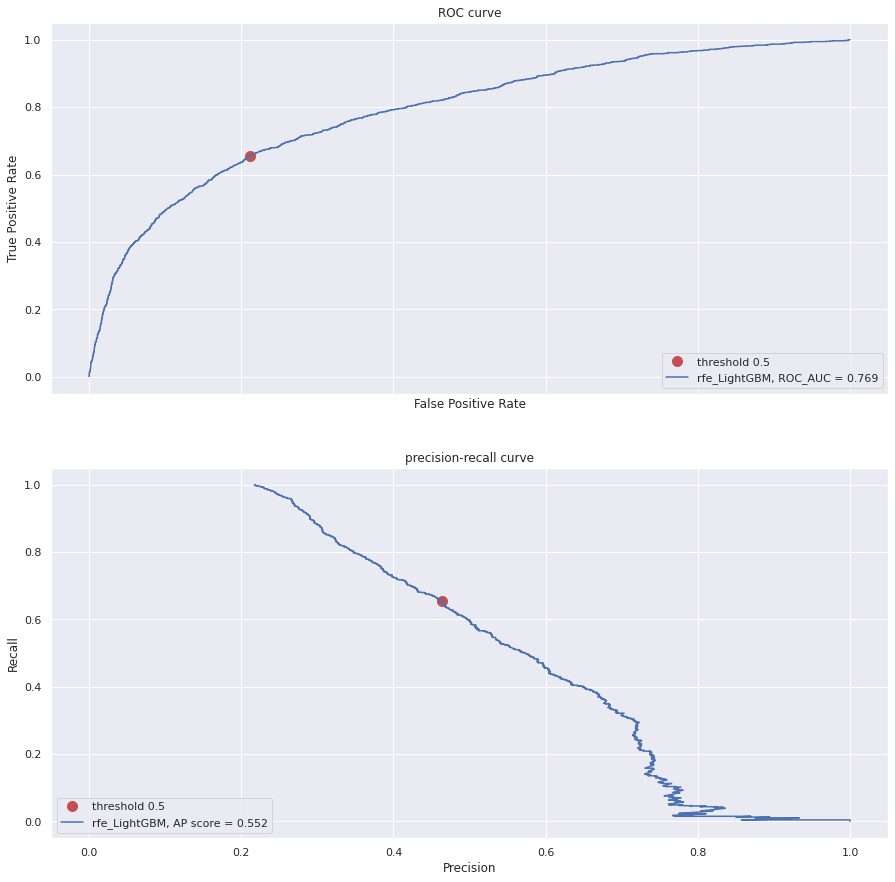

In [40]:
fig, ax = plt.subplots(2, sharex=True, figsize=[15, 15])
precision, recall, thresholds = precision_recall_curve(y_test, pred_proba)
fpr, tpr, thresholds = roc_curve(y_test,pred_proba)
roc_auc = roc_auc_score(y_test, pred_proba)
ap = average_precision_score(y_test, pred_proba)
default_threshold = np.argmin(np.abs(thresholds - 0.5))
ax[0].plot(fpr[default_threshold],tpr[default_threshold],"or",markersize=10,label="threshold 0.5")
ax[0].plot(fpr,tpr, label = name+', ROC_AUC = %0.3f' % model_roc_auc)
ax[0].set_xlabel("False Positive Rate", fontsize= 12)
ax[0].set_ylabel("True Positive Rate", fontsize= 12)
ax[0].set_title("ROC curve")
ax[0].legend(loc="lower right")

ax[1].plot(precision_score(y_test, pred),recall_score(y_test, pred),"or",markersize=10,label="threshold 0.5")
ax[1].plot(precision, recall, label= name+', AP score = %0.3f' % ap)
ax[1].set_ylabel("Recall")
ax[1].set_xlabel("Precision")
ax[1].set_title("precision-recall curve")
ax[1].legend(loc="lower left")